In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skl2onnx import to_onnx
from onnxruntime import InferenceSession
%matplotlib inline

In [2]:
# Load the data
data_path = "filled_data.csv"
data = pd.read_csv(data_path)

# Extract the relevant columns
datetime_column = pd.to_datetime(data['datetime'])
# Get all feature columns except 'datetime'
feature_columns = data.columns[1:]  # Exclude the 'datetime' column



In [3]:
def build_training_data(hourly_data_path):
    """Build training data from hourly data function. Skips NaN'd days."""

    hourly_data = pd.read_csv(hourly_data_path)
    
    print('Loaded hourly data')

    # integrated power consumption

    dec = [] # daily energy consumption
    t_dec = []

    time = pd.to_datetime(hourly_data['datetime']).dt.strftime('%Y-%m-%dT%H:%M:%S').values.astype('datetime64[s]')

    
    power_consumption = hourly_data['kw_total_zone2'].values

    for ti, t in enumerate(time):
        tmp_t = pd.Timestamp(t)

        if np.isclose(tmp_t.hour, 0) and np.isclose(tmp_t.minute, 0):

            day_end = np.datetime64(tmp_t + pd.Timedelta(days=1))
            ind = np.where((tmp_t < time) & (time < day_end), True, False)

            if len(time[ind]) > 0 and not np.isnan(power_consumption[ind]).any():
                t_dec.append(np.datetime64(tmp_t).astype('datetime64[s]'))
                dec.append(np.trapz(power_consumption[ind], time[ind].astype(int))/3600) # integrated kW to kJ then to kWh

    # time series of daily energy consumption
    t_dec = np.array(t_dec)
    dec = np.array(dec)

    print('Calculated daily energy consumption')

    # seperating predictors

    N = 7 # N days of predictors beforehand
    final_ind = []
    final_hourly = []

    predictor_window = pd.Timedelta(days=N)

    for ti, t in enumerate(t_dec):
        tmp_t = pd.Timestamp(t)
        ind = np.where((tmp_t - predictor_window <= time) & (time < tmp_t), True, False) # finding indices within the N prior days

        bad_ind = np.isnan(hourly_data.iloc[ind, 1::].values)
        if len(time[ind]) >= 24 * N and not bad_ind.any(): # rejecting any data with NaNs; useful for the student dataset
            final_ind.append(ti)
            final_hourly.append(hourly_data.iloc[ind, 1::].values) # dropping datetime column

    # getting targets and predictors
    target_time = t_dec[final_ind]
    targets = dec[final_ind]
    predictors = np.array(final_hourly)

    print('Calculated predictor window')

    return target_time, targets, predictors


In [4]:
data.shape

(17520, 28)

In [5]:
target_time, target, predictors = build_training_data('filled_data.csv')
print(target.shape)
print(predictors.shape)

Loaded hourly data
Calculated daily energy consumption
Calculated predictor window
(723,)
(723, 168, 27)


In [6]:
# Exclude the first column (datetime)
input_data = data.iloc[:, 1:]

# Calculate the number of days (excluding the first week)
num_days = 730 - 7  # 730 days with the first 7 days skipped

# Initialize the 3D array
targets = np.zeros((num_days, 24, input_data.shape[1]))

# Iterate through each day and extract the data
for day in range(num_days):
    start_index = day * 24 + 7 * 24
    end_index = start_index + 24
    targets[day, :, :] = input_data.iloc[start_index:end_index, :]

targets = targets[:, :, 22]




In [7]:
target.shape

(723,)

In [8]:
from sklearn.preprocessing import MinMaxScaler

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape the array to (723 * 168, 27) to apply MinMaxScaler
reshaped_predictors = predictors.reshape(-1, 27)

# Fit and transform the data
scaled_predictors = scaler.fit_transform(reshaped_predictors)

# Reshape the scaled data back to the original shape
predictors = scaled_predictors.reshape(predictors.shape)


reshaped_target = target.reshape(-1, 1)
targets = scaler.fit_transform(targets)
# target = scaler.fit_transform(reshaped_target)

print(predictors.shape)
print(targets.shape)


(723, 168, 27)
(723, 24)


In [9]:
from sklearn.model_selection import train_test_split

# split_index = int(len(targets) * 0.8)

# # Split the vectors into training and testing sets
# train_y, test_y = target[:split_index], target[split_index:]
# train_X, test_X = predictors[:split_index], predictors[split_index:]

train_X, test_X, train_y, test_y, indices_train, indices_test = train_test_split(predictors, targets, np.arange(len(targets)), test_size=0.2, random_state=55)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(578, 168, 27) (578, 24) (145, 168, 27) (145, 24)


In [47]:
test_y[0]

array([0.12933231, 0.0894327 , 0.10353798, 0.09147465, 0.08582695,
       0.06074694, 0.06393759, 0.08797208, 0.07327911, 0.08935433,
       0.10035937, 0.09476929, 0.17362978, 0.13079394, 0.13337023,
       0.1610515 , 0.11506849, 0.12425542, 0.09230587, 0.11571109,
       0.11367798, 0.13059092, 0.1202011 , 0.11136658])

In [10]:
len(indices_test)

145

In [11]:
def relative_squared_error(y_pred, y_true):
    """Relative squared error (RSE; also called relative mean square error). < 1 is good, = 1 is bad, > 1 really bad."""
    return K.mean((y_pred - y_true)**2)/K.mean((y_true - K.mean(y_true))**2)

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Lambda, ReLU
from tensorflow.keras import activations
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [13]:
[x.shape for x in [train_X, train_y, test_X, test_y]]

[(578, 168, 27), (578, 24), (145, 168, 27), (145, 24)]

In [54]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(27)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [55]:


# Design Lambda
int_layer = Lambda(lambda x: K.sum(x, axis=1))

# design network
model = Sequential()
model.add(LSTM(27, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Attention(27))
model.add(Dense(32, activation=activations.relu))
model.add(Dense(24))
model.compile(loss='mse', optimizer='adam')
# fit network





In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 168, 27)           5940      
                                                                 
 attention_2 (Attention)     (None, 27)                1512      
                                                                 
 dense_10 (Dense)            (None, 32)                896       
                                                                 
 dense_11 (Dense)            (None, 24)                792       
                                                                 
Total params: 9,140
Trainable params: 9,140
Non-trainable params: 0
_________________________________________________________________


In [58]:
history = model.fit(train_X, train_y, epochs=20, batch_size=2, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
289/289 - 14s - loss: 0.0120 - val_loss: 0.0137 - 14s/epoch - 48ms/step
Epoch 2/20
289/289 - 13s - loss: 0.0116 - val_loss: 0.0135 - 13s/epoch - 44ms/step
Epoch 3/20
289/289 - 12s - loss: 0.0113 - val_loss: 0.0135 - 12s/epoch - 43ms/step
Epoch 4/20
289/289 - 12s - loss: 0.0110 - val_loss: 0.0131 - 12s/epoch - 43ms/step
Epoch 5/20
289/289 - 12s - loss: 0.0106 - val_loss: 0.0127 - 12s/epoch - 43ms/step
Epoch 6/20
289/289 - 13s - loss: 0.0104 - val_loss: 0.0123 - 13s/epoch - 44ms/step
Epoch 7/20
289/289 - 12s - loss: 0.0103 - val_loss: 0.0125 - 12s/epoch - 43ms/step
Epoch 8/20
289/289 - 12s - loss: 0.0101 - val_loss: 0.0121 - 12s/epoch - 43ms/step
Epoch 9/20
289/289 - 13s - loss: 0.0100 - val_loss: 0.0120 - 13s/epoch - 44ms/step
Epoch 10/20
289/289 - 12s - loss: 0.0098 - val_loss: 0.0119 - 12s/epoch - 43ms/step
Epoch 11/20
289/289 - 12s - loss: 0.0096 - val_loss: 0.0120 - 12s/epoch - 43ms/step
Epoch 12/20
289/289 - 12s - loss: 0.0095 - val_loss: 0.0123 - 12s/epoch - 43ms/step
E

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

train_target = target[indices_train]
test_target = target[indices_test]

class Attention(nn.Module):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = nn.Linear(in_features=27, out_features=units)
        self.V = nn.Linear(in_features=units, out_features=27)

    def forward(self, inputs):
        score = F.tanh(self.W(inputs))
        attention_weights = F.softmax(self.V(score), dim=1)
        context_vector = attention_weights * inputs
        context_vector = torch.sum(context_vector, dim=1)
        return context_vector
    
# Assuming you have a function for relative squared error
def relative_squared_error(y_pred, y_true):
    """Relative squared error (RSE; also called relative mean square error). < 1 is good, = 1 is bad, > 1 really bad."""
    return np.mean((y_pred - y_true)**2)/np.mean((y_true - y_true.mean())**2)

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.lstm = nn.LSTM(input_size=27, hidden_size=27, batch_first=True)
        self.attention = Attention(27)
        self.dense1 = nn.Linear(27, 32)
        self.dense2 = nn.Linear(32, 24)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        attention_output = self.attention(lstm_output)
        dense1_output = F.relu(self.dense1(attention_output))
        final_output = self.dense2(dense1_output)
        return final_output

# Create an instance of the model
model = CustomModel()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Convert data to torch tensors
train_X_tensor = torch.Tensor(train_X)
train_y_tensor = torch.Tensor(train_y)

test_X_tensor = torch.Tensor(test_X)
test_y_tensor = torch.Tensor(test_y)

# Create DataLoader for batches
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=18, shuffle=True)

num_epochs = 200

for epoch in range(num_epochs):
    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        train_loss = criterion(outputs, batch_y)

        # Backward and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_X_tensor)
        val_loss = criterion(val_outputs, test_y_tensor)

    # print(val_outputs.shape)
    # print('--------------------------')
    # print(test_y_tensor.shape)
    # make a prediction
    # yhat = model.predict(predictors)
    # yhat_test = model.predict(test_X)
    # yhat_train = model.predict(train_X)

    # inv_yhat_train = scaler.inverse_transform(outputs.detach().numpy())
    inv_yhat_test = scaler.inverse_transform(val_outputs.detach().numpy())

    
    # print(val_outputs)
    # print(inv_yhat_test)

    # predicted_kw_zone2_train = np.trapz(inv_yhat_train, axis=1)
    predicted_kw_zone2_test = np.trapz(inv_yhat_test, axis=1)
    

    # Calculate accuracy using relative squared error
    # train_accuracy = relative_squared_error(predicted_kw_zone2_train, train_target).item()
    val_RSE = relative_squared_error(predicted_kw_zone2_test, test_target).item()

    # Print metrics
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss.item():.4f}, '
          f'Validation Loss: {val_loss.item():.4f}, '
          f'Validation RSE: {val_RSE:.4f}')
    

print(val_outputs[0])


Epoch [1/200], Train Loss: 0.0214, Validation Loss: 0.0394, Validation RSE: 1.0741
Epoch [2/200], Train Loss: 0.0319, Validation Loss: 0.0229, Validation RSE: 0.5384
Epoch [3/200], Train Loss: 0.0200, Validation Loss: 0.0175, Validation RSE: 0.3663
Epoch [4/200], Train Loss: 0.0049, Validation Loss: 0.0171, Validation RSE: 0.3834
Epoch [5/200], Train Loss: 0.0136, Validation Loss: 0.0158, Validation RSE: 0.3254
Epoch [6/200], Train Loss: 0.0095, Validation Loss: 0.0163, Validation RSE: 0.3332
Epoch [7/200], Train Loss: 0.0402, Validation Loss: 0.0156, Validation RSE: 0.3289
Epoch [8/200], Train Loss: 0.0105, Validation Loss: 0.0157, Validation RSE: 0.3387
Epoch [9/200], Train Loss: 0.0051, Validation Loss: 0.0170, Validation RSE: 0.4225
Epoch [10/200], Train Loss: 0.0162, Validation Loss: 0.0157, Validation RSE: 0.3417
Epoch [11/200], Train Loss: 0.0281, Validation Loss: 0.0161, Validation RSE: 0.3760
Epoch [12/200], Train Loss: 0.0293, Validation Loss: 0.0155, Validation RSE: 0.3123
E

In [83]:
inv_yhat_test = scaler.inverse_transform(val_outputs.detach().numpy())
np.trapz(inv_yhat_test[0])

20.597189

In [ ]:
array([0.12933231, 0.0894327 , 0.10353798, 0.09147465, 0.08582695,
       0.06074694, 0.06393759, 0.08797208, 0.07327911, 0.08935433,
       0.10035937, 0.09476929, 0.17362978, 0.13079394, 0.13337023,
       0.1610515 , 0.11506849, 0.12425542, 0.09230587, 0.11571109,
       0.11367798, 0.13059092, 0.1202011 , 0.11136658])

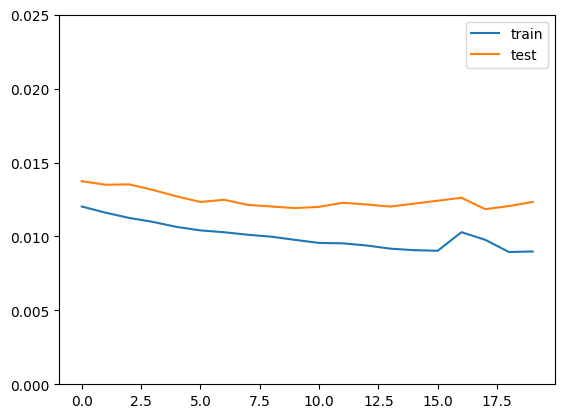

In [59]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim(0, 0.025)
plt.legend()
plt.show()

In [60]:
# make a prediction
yhat = model.predict(predictors)
yhat_test = model.predict(test_X)
yhat_train = model.predict(train_X)
print(yhat.shape, yhat_test.shape, yhat_train.shape)

19/19 [==============================] - 0s 13ms/step
(723, 24) (145, 24) (578, 24)


In [61]:
train_target = target[indices_train]
test_target = target[indices_test]
print(train_target.shape, test_target.shape)

(578,) (145,)


In [62]:
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat_train = scaler.inverse_transform(yhat_train)
inv_yhat_test = scaler.inverse_transform(yhat_test)
print(inv_yhat.shape, inv_yhat_train.shape, inv_yhat_test.shape)

(723, 24) (578, 24) (145, 24)


In [63]:
predicted_kw_zone2 = np.trapz(inv_yhat, axis=1)
predicted_kw_zone2_train = np.trapz(inv_yhat_train, axis=1)
predicted_kw_zone2_test = np.trapz(inv_yhat_test, axis=1)
print(predicted_kw_zone2.shape, predicted_kw_zone2_train.shape, predicted_kw_zone2_test.shape)

(723,) (578,) (145,)


In [64]:
for i in range (len(predicted_kw_zone2_test)):
  print(predicted_kw_zone2_test[i], test_target[i])

33.22029 21.552499999999995
50.446865 48.31099999999999
27.910725 26.824999999999996
46.293953 51.9835
111.750656 111.908
38.607407 40.4115
51.278214 35.86899999999999
88.41078 95.85650000000001
89.755104 95.8615
35.137943 33.921499999999995
27.474205 38.78849999999999
41.53313 31.230500000000006
28.949415 14.036000000000005
133.64299 83.88900000000001
23.565062 53.496500000000005
66.25008 64.88199999999999
36.761593 70.37550000000002
35.191856 53.62199999999999
114.11981 109.47749999999998
83.73123 77.55449999999999
30.203043 29.666999999999994
56.24201 47.337
97.356316 77.0
61.86355 59.13
21.193386 16.6995
26.561018 23.502
44.684208 49.892999999999994
145.29504 94.03700000000002
36.886894 39.34
26.4857 36.8225
139.11278 115.0815
55.18759 46.69400000000001
29.530775 37.298500000000004
75.55006 71.91650000000001
94.35646 97.34750000000001
98.38162 102.75099999999999
37.28218 29.567999999999994
26.106434 26.331000000000003
30.600834 37.652
34.489952 47.477500000000006
26.948223 37.89500

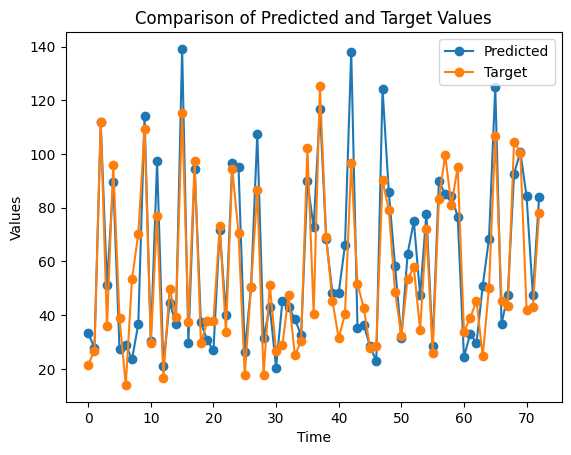

In [65]:
# Plotting
plt.plot(predicted_kw_zone2_test[::2], 'o-', label='Predicted')
plt.plot(test_target[::2], 'o-', label='Target')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Comparison of Predicted and Target Values')
plt.legend()
plt.show()

In [66]:
def relative_squared_error(y_pred, y_true):
    """Relative squared error (RSE; also called relative mean square error). < 1 is good, = 1 is bad, > 1 really bad."""
    return np.mean((y_pred - y_true)**2)/np.mean((y_true - y_true.mean())**2)

print(relative_squared_error(predicted_kw_zone2_test, test_target))

0.255881040297981


In [211]:
# Calculate absolute difference or squared difference
absolute_diff = np.abs(predicted_kw_zone2 - target)
# Or squared_diff = (y_true - y_pred)**2

# Set a threshold 
threshold = 20  # Example threshold

# Find indices where the difference exceeds the threshold
far_away_indices = np.where(absolute_diff > threshold)[0]


far_away_in_test = np.intersect1d(far_away_indices, indices_test)
print(len(far_away_in_test))

24


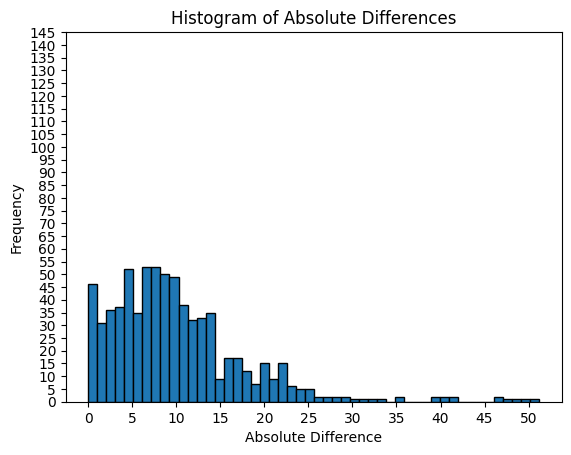

In [177]:
# Plot the histogram of absolute differences
plt.hist(absolute_diff, bins=50, edgecolor='black')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Absolute Differences')
plt.xticks(np.arange(0, max(absolute_diff), 5))
plt.yticks(np.arange(0, 150, 5))
plt.show()